In [1]:
import os
os.chdir("/project/validating_attribution_techniques/")

In [2]:
!nvidia-smi

Tue Oct 31 21:35:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:B1:00.0 Off |                  N/A |
| 27%   48C    P2              74W / 250W |    807MiB / 11264MiB |     36%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus("1")
enable_web_access()

In [4]:
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

# from shardul.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from torchvision.models import resnet50, resnet18, vgg16, inception_v3
from torchvision.models.inception import Inception3


from shardul.api.viz import visualize_saliency_overlay
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images


from commons.api.method.attribution import attribution


from commons.api.metric.compare_metrics import normalize, match_hist, normalize_map
from commons.api.metric.compare_metrics import SIM, CC, NSS, AUC_Judd, wasserstein_distance
from commons.api.metric.compare_metrics import calculate_metrics

In [5]:
os.chdir("/project/validating_attribution_techniques/torchCAM")
from torchcam.methods.gradient import SmoothGradCAMpp, GradCAMpp, GradCAM, LayerCAM
from torchcam.methods.activation import ScoreCAM
from torchcam.utils import overlay_mask

In [6]:
os.chdir("/project/validating_attribution_techniques/")

In [7]:
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.figure import Figure
from io import BytesIO
from matplotlib.transforms import IdentityTransform

from PIL import Image
from numpy import random
import json
# import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from cv2 import EMD
from captum.attr import LayerAttribution, LayerGradCam
import cv2
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image 
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

In [8]:

def text_to_rgba(s, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none", figsize=(10, 10))
    fig.text(0, 0, s, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

In [9]:
def apply_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.copy(image)
    patched_image[top_left_y : top_left_y+patch_size,
                  top_left_x : top_left_x+patch_size, :] = 0
    return patched_image
def generate_img_occlusion_list(img, saliency, patch_size, saliency_reduce_func=np.mean):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    saliency = np.array(Image.fromarray(saliency).resize(img.shape[0], img.shape[1]))
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            occlusion_saliency_statistic.append(saliency_reduce_func(saliency[top_left_y : top_left_y+patch_size,
                                                                              top_left_x : top_left_x+patch_size]))
            
    return np.array(occlusion_img_list), np.array(occlusion_saliency_statistic)
def generate_img_occlusion_list_no_saliency(img, patch_size):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            
    return np.array(occlusion_img_list)

In [10]:
classes = get_imagenet_classes()

In [11]:
#Load all images
images = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/images_2_fixed.npy', allow_pickle=True)
masks = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/obj_masks_2_fixed.npy', allow_pickle=True)

In [12]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model_resnet50 = resnet50(pretrained=True).to(device).eval()
model_resnet18 = resnet18(pretrained=True).to(device).eval()
# model_vgg = vgg16(pretrained=True).to(device).eval()
# model_inception3 = inception_v3(pretrained=True).to(device).eval()
model_resnet18.eval()

/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# target_layer = model_resnet50.layer3[-1]
target_layer = model_resnet50.layer4[-1].conv3 #ResNet50

target_layer_index = 28
# target_layer_vgg = "features.28"
# target_layer_inception = model_inception3.Mixed_7c.branch3x3dbl_3b
target_layer_res18 = model_resnet18.layer4[-1].conv2



In [14]:
target_layer_res18

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Occlusion

# Inter Model - ResNet50 - ResnNet18 Vs Vgg16 vs InceptionV3
- ResNet50 is base model

In [16]:
def initialize_metrics_values(techniques, metrics):
    metrics_values = {}
    for technique in techniques:
        metrics_values[technique] = {}
        for metric in metrics:
            metrics_values[technique][metric] = []
    return metrics_values

metrics_values = {
    "GradCAM": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    },
    "ScoreCAM": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    },
    "LayerCAM": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    },
    "SmoothGradCAMpp": {
        "sim": [],
        "cc": [],
        "nss": [],
        "auc": [],
        "emd": [],
        "ior": []
    }
}

# Define the techniques and metrics you want to collect
techniques = ["GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
metrics = ["sim", "cc", "nss", "auc", "emd", "ior"]

### Only one columns

In [39]:

indexes = [i for i in range(0, 61)]

Iteration, 0


NameError: name 'model_resnet18' is not defined

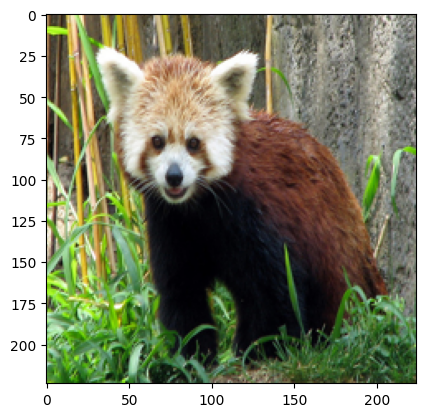

In [18]:
models = ["ResNet18", "VGG16", "InceptionV3"]
# indexes = [0, 1]
# img_idx = 0

for img_idx in indexes:
    print(f"Iteration, {img_idx}")
    gradcam = np.array([])
    scorecam = np.array([])
    smoothgradcampp = np.array([])
    layercam = np.array([])
    original_image = Image.fromarray(images[img_idx])
    imshow(original_image)
    input_tensor = transform(original_image).to(device)
    mask = masks[img_idx]
    #if in case you do not want to specify target layer(default is set to 'layer4')
    grad_cam, grad_idx, grad_probs = attribution(model_resnet50, input_tensor, "GradCAM", target_layer)
    score_cam, score_idx, score_probs = attribution(model_resnet50, input_tensor, "ScoreCAM", target_layer)   
    smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model_resnet50, input_tensor, "SmoothGradCAMpp", target_layer)
    layer_cam, layer_idx, layer_probs = attribution(model_resnet50, input_tensor, "LayerCAM", target_layer)
    # fig, axes = plt.subplots(ncols=2, nrows=1)
    fig, axes = plt.subplots(ncols=4, nrows=1)
    
    fig.set_figwidth(12)
    fig.set_layout_engine('tight')
    fig.suptitle("Attribution Techniques", fontsize=16, fontweight="bold",y=0.9)
    # fig.set_figheight(40)
    # Turn off the axis for each subplot
    for ax in axes:
        ax.axis('off')
    # Titles for each subplot
    titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
    
    visualize_saliency_overlay(axes[0], original_image, grad_cam, grad_probs, grad_idx, classes);
    visualize_saliency_overlay(axes[1], original_image, score_cam, score_probs, score_idx, classes);
    visualize_saliency_overlay(axes[2], original_image, smoothgradpp_cam, smoothgradpp_probs, smoothgradpp_idx, classes);
    visualize_saliency_overlay(axes[3], original_image, layer_cam, layer_probs, layer_idx, classes);
    for i, ax in enumerate(axes):
        ax.text(0.5, -0.1, titles[i], horizontalalignment='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Results/Ground_truth_{img_idx}.png")
    plt.close(fig)
    pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model_resnet18, input_tensor, "GradCAM", target_layer)
    pertubed_score_cam, pertubed_score_idx, pertubed_score_probs = attribution(model_resnet18, input_tensor, "ScoreCAM", target_layer)   
    pertubed_smoothgradpp_cam, pertubed_smoothgradpp_idx, pertubed_smoothgradpp_probs = attribution(model_resnet18, input_tensor, "SmoothGradCAMpp", target_layer)
    pertubed_layer_cam, pertubed_layer_idx, pertubed_layer_probs = attribution(model_resnet18, input_tensor, "LayerCAM", target_layer)
    
    
    # img_idx = 0
    
    
    
    # print(rows)
    fig, axes = plt.subplots(ncols=8, nrows=1)
    fig.suptitle("ResNet50 Vs VGG16", fontsize=16, fontweight='bold', x=0.5)
    # Iterate through axes and turn off the axes for each subplot
    for ax in axes:
        ax.axis('off')
    
    for i, ax in enumerate(axes):
    # Check if the current column index is in [0, 2, 4, 6]
        if i in [0, 2, 4, 6]:
            ax.text(0.5, -0.1, titles[i // 2], horizontalalignment='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    
    # fig.set_figheight(15)
    fig.set_figwidth(20)
    visualize_saliency_overlay(axes[0], original_image, pertubed_grad_cam, pertubed_grad_probs, pertubed_grad_idx, classes);    
    visualize_saliency_overlay(axes[2], original_image, pertubed_score_cam, pertubed_score_probs, pertubed_score_idx, classes);
    visualize_saliency_overlay(axes[4], original_image, pertubed_smoothgradpp_cam, pertubed_smoothgradpp_probs, pertubed_smoothgradpp_idx, classes);    
    visualize_saliency_overlay(axes[6], original_image, pertubed_layer_cam, pertubed_layer_probs, pertubed_layer_idx, classes);
    
        
    sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, pertubed_grad_cam, mask) 
    text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}\nAUC: {auc_grad:.2f}\nEMD: {emd_grad:.2f}\nIOR: {ior_grad:.2f}"
    
    sim_score, cc_score, nss_score, auc_score, emd_score, ior_score = calculate_metrics(score_cam, pertubed_score_cam, mask) 
    text_score = f"Sim: {sim_score:.2f}\nCC: {cc_score:.2f}\nNSS: {nss_score:.2f}\nAUC: {auc_score:.2f}\nEMD: {emd_score:.2f}\nIOR: {ior_score:.2f}"
    
    sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth = calculate_metrics(smoothgradpp_cam, pertubed_smoothgradpp_cam, mask) 
    text_smooth = f"Sim: {sim_smooth:.2f}\nCC: {cc_smooth:.2f}\nNSS: {nss_smooth:.2f}\nAUC: {auc_smooth:.2f}\nEMD: {emd_smooth:.2f}\nIOR: {ior_smooth:.2f}"
    
    sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer = calculate_metrics(layer_cam, pertubed_layer_cam, mask) 
    text_layer = f"Sim: {sim_layer:.2f}\nCC: {cc_layer:.2f}\nNSS: {nss_layer:.2f}\nAUC: {auc_layer:.2f}\nEMD: {emd_layer:.2f}\nIOR: {ior_layer:.2f}"
        
    #     axis.text(2*10, axis.get_ylim()[0]-2*10, f"$IOR={ior:.2f}$", fontsize=15, color="white", bbox={'facecolor' : "red", "alpha" : 0.5, "pad" : 5})
    axes[1].imshow(text_to_rgba(text_grad, color="blue", fontsize=10, dpi=200))
    axes[3].imshow(text_to_rgba(text_score, color="blue", fontsize=10, dpi=200))
    axes[5].imshow(text_to_rgba(text_smooth, color="blue", fontsize=10, dpi=200))
    axes[7].imshow(text_to_rgba(text_layer, color="blue", fontsize=10, dpi=200))

    for technique in techniques:
        for metric in metrics:
            if technique == "GradCAM":
                calculated_value = locals()[metric.lower() + "_grad"]
            elif technique == "ScoreCAM":
                calculated_value = locals()[metric.lower() + "_score"]
            elif technique == "SmoothGradCAMpp":
                calculated_value = locals()[metric.lower() + "_smooth"]
            elif technique == "LayerCAM":
                calculated_value = locals()[metric.lower() + "_layer"]
                # Append the calculated metric to the appropriate list
            metrics_values[technique][metric].append(calculated_value)

    for technique in techniques:
        for metric in metrics:
            metrics_values[technique][metric] = [float(value) for value in metrics_values[technique][metric]]
    
    
    gradcam = np.append(gradcam, pertubed_grad_cam)
    scorecam = np.append(scorecam, pertubed_score_cam)
    smoothgradcampp = np.append(smoothgradcampp, pertubed_smoothgradpp_cam)
    layercam = np.append(layercam, pertubed_layer_cam)
    
    
    
    # fig.suptitle("GradCAM vs ScoreCAM", fontsize=16, fontweight="bold", y=0.9)
    # fig.show()
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/Images/ResNet18/ResnNet50_ResNet18_{img_idx}.png")
    plt.close(fig)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Saliency/{models[0]}_GradCAM_saliency_idx_{img_idx}.npy", gradcam)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Saliency/{models[0]}_ScoreCAM_saliency_idx_{img_idx}.npy", scorecam)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Saliency/{models[0]}_SmoothGradCAM_saliency_idx_{img_idx}.npy", smoothgradcampp)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Saliency/{models[0]}_LayerCAM_saliency_idx_{img_idx}.npy", layercam)

    output_file = f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Results/metrics_{models[0]}_{img_idx}.json"
    if os.path.exists(output_file):
        os.remove(output_file)
    with open(output_file, 'w') as json_file:
        json.dump(metrics_values, json_file, indent=4)

    break



In [31]:
# # Define the base directory and subfolders
# base_dir = "/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/"
# subfolders = ["InceptionV3", "ResNet18", "VGG16"]

# # Iterate through subfolders and create the directory structure
# for folder in subfolders:
#     folder_path = f"{base_dir}/{folder}"
#     for i in range(61):  # Create 61 subfolders from Img_0 to Img_60
#         img_folder = f"Img_{i}"
#         img_path = f"{folder_path}/{img_folder}"
#         # Create Results and Saliency subfolders
#         !mkdir -p "$img_path/Results"
#         !mkdir -p "$img_path/Saliency"


### Two columns

In [17]:

indexes = [i for i in range(0, 61)]

In [18]:
def resize_cam(cam, target_size):
    # Resize the CAM map using np.resize
    resized_cam = np.resize(cam, target_size)
    return resized_cam

Iteration, 0
Iteration, 1
Iteration, 2
Iteration, 3


/project/validating_attribution_techniques/shardul/api/viz.py:21: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap / np.max(heatmap)) * 255.0
/project/validating_attribution_techniques/commons/api/metric/compare_metrics.py:55: RuntimeWarning: invalid value encountered in divide
  res = (x - np.min(x)) / (np.max(x) - np.min(x))
/project/validating_attribution_techniques/commons/api/metric/compare_metrics.py:53: RuntimeWarning: invalid value encountered in divide
  res = (x - np.mean(x)) / np.std(x)
/scratch/shkulkar/python/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch/shkulkar/python/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


no fixation to predict
Iteration, 4
Iteration, 5
Iteration, 6
Iteration, 7
Iteration, 8
Iteration, 9
Iteration, 10
no fixation to predict
Iteration, 11
Iteration, 12
no fixation to predict
Iteration, 13
Iteration, 14
no fixation to predict
Iteration, 15
Iteration, 16
Iteration, 17
no fixation to predict
Iteration, 18
Iteration, 19
no fixation to predict
Iteration, 20
Iteration, 21
no fixation to predict
Iteration, 22
no fixation to predict
Iteration, 23
Iteration, 24
Iteration, 25
Iteration, 26
no fixation to predict
Iteration, 27
Iteration, 28
Iteration, 29
Iteration, 30
Iteration, 31
no fixation to predict
Iteration, 32
Iteration, 33
Iteration, 34
Iteration, 35
Iteration, 36
Iteration, 37
no fixation to predict
Iteration, 38
Iteration, 39
no fixation to predict
Iteration, 40
Iteration, 41
no fixation to predict
Iteration, 42
no fixation to predict
Iteration, 43
Iteration, 44
Iteration, 45
no fixation to predict
Iteration, 46
Iteration, 47
no fixation to predict
Iteration, 48
no fixat

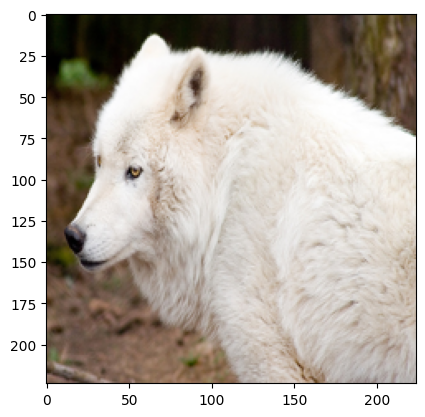

In [20]:
models = ["ResNet18", "VGG16", "InceptionV3"]
# indexes = [0, 1]
# img_idx = 0

for img_idx in indexes:
    print(f"Iteration, {img_idx}")
    gradcam = np.array([])
    scorecam = np.array([])
    smoothgradcampp = np.array([])
    layercam = np.array([])
    original_image = Image.fromarray(images[img_idx])
    imshow(original_image)
    input_tensor = transform(original_image).to(device)
    mask = masks[img_idx]
    #if in case you do not want to specify target layer(default is set to 'layer4')
    grad_cam, grad_idx, grad_probs = attribution(model_resnet50, input_tensor, "GradCAM", target_layer)
    score_cam, score_idx, score_probs = attribution(model_resnet50, input_tensor, "ScoreCAM", target_layer)   
    smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model_resnet50, input_tensor, "SmoothGradCAMpp", target_layer)
    layer_cam, layer_idx, layer_probs = attribution(model_resnet50, input_tensor, "LayerCAM", target_layer)
    # fig, axes = plt.subplots(ncols=2, nrows=1)
    fig, axes = plt.subplots(ncols=4, nrows=1)
    
    fig.set_figwidth(12)
    fig.set_layout_engine('tight')
    fig.suptitle("Attribution Techniques", fontsize=16, fontweight="bold",y=0.9)
    # fig.set_figheight(40)
    # Turn off the axis for each subplot
    for ax in axes:
        ax.axis('off')
    # Titles for each subplot
    titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
    
    visualize_saliency_overlay(axes[0], original_image, grad_cam, grad_probs, grad_idx, classes);
    visualize_saliency_overlay(axes[1], original_image, score_cam, score_probs, score_idx, classes);
    visualize_saliency_overlay(axes[2], original_image, smoothgradpp_cam, smoothgradpp_probs, smoothgradpp_idx, classes);
    visualize_saliency_overlay(axes[3], original_image, layer_cam, layer_probs, layer_idx, classes);
    for i, ax in enumerate(axes):
        ax.text(0.5, -0.1, titles[i], horizontalalignment='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Results/Ground_truth_{img_idx}.png")
    plt.close(fig)
    pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model_resnet18, input_tensor, "GradCAM", target_layer_res18)
    pertubed_score_cam, pertubed_score_idx, pertubed_score_probs = attribution(model_resnet18, input_tensor, "ScoreCAM", target_layer_res18)   
    pertubed_smoothgradpp_cam, pertubed_smoothgradpp_idx, pertubed_smoothgradpp_probs = attribution(model_resnet18, input_tensor, "SmoothGradCAMpp", target_layer_res18)
    pertubed_layer_cam, pertubed_layer_idx, pertubed_layer_probs = attribution(model_resnet18, input_tensor, "LayerCAM", target_layer_res18)

    # pertubed_grad_cam = resize_cam(pertubed_grad_cam, grad_cam.shape)
    # pertubed_score_cam = resize_cam(pertubed_score_cam, score_cam.shape)
    # pertubed_smoothgradpp_cam = resize_cam(pertubed_smoothgradpp_cam, smoothgradpp_cam.shape)
    # pertubed_layer_cam = resize_cam(pertubed_layer_cam, layer_cam.shape)

    # grad_cam = resize_cam(grad_cam, pertubed_grad_cam.shape)
    # score_cam = resize_cam(score_cam, pertubed_score_cam.shape)
    # smoothgradpp_cam = resize_cam(smoothgradpp_cam, pertubed_smoothgradpp_cam.shape)
    # layer_cam = resize_cam(layer_cam, pertubed_layer_cam.shape)

    
    fig, axes = plt.subplots(ncols=8, nrows=2)
    fig.suptitle("ResNet50 Vs ResNet18", fontsize=16, fontweight='bold', x=0.5)
    # Iterate through axes and turn off the axes for each subplot
    for row in axes:
        for ax in row:
            ax.axis('off')

    for col in [0, 2, 4, 6]:
        # Add the title at the bottom of the image in the second row
        title = titles[col // 2]
        axes[1, col].text(0.5, -0.12, title, horizontalalignment='center', fontsize=12, fontweight='bold', transform=axes[1, col].transAxes)
    # fig.set_figheight(15)
    fig.set_figwidth(20)

    

    visualize_saliency_overlay(axes[0, 0], original_image, grad_cam, grad_probs, grad_idx, classes);
    visualize_saliency_overlay(axes[0, 2], original_image, score_cam, score_probs, score_idx, classes);
    visualize_saliency_overlay(axes[0, 4], original_image, smoothgradpp_cam, smoothgradpp_probs, smoothgradpp_idx, classes);
    visualize_saliency_overlay(axes[0, 6], original_image, layer_cam, layer_probs, layer_idx, classes);
    
    # for row in range(axes.shape[0]):
    visualize_saliency_overlay(axes[1, 0], original_image, pertubed_grad_cam, pertubed_grad_probs, pertubed_grad_idx, classes);    
    visualize_saliency_overlay(axes[1, 2], original_image, pertubed_score_cam, pertubed_score_probs, pertubed_score_idx, classes);
    visualize_saliency_overlay(axes[1, 4], original_image, pertubed_smoothgradpp_cam, pertubed_smoothgradpp_probs, pertubed_smoothgradpp_idx, classes);    
    visualize_saliency_overlay(axes[1, 6], original_image, pertubed_layer_cam, pertubed_layer_probs, pertubed_layer_idx, classes);
    
        
    sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(grad_cam, pertubed_grad_cam, mask) 
    text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}\nAUC: {auc_grad:.2f}\nEMD: {emd_grad:.2f}\nIOR: {ior_grad:.2f}"
    
    sim_score, cc_score, nss_score, auc_score, emd_score, ior_score = calculate_metrics(score_cam, pertubed_score_cam, mask) 
    text_score = f"Sim: {sim_score:.2f}\nCC: {cc_score:.2f}\nNSS: {nss_score:.2f}\nAUC: {auc_score:.2f}\nEMD: {emd_score:.2f}\nIOR: {ior_score:.2f}"
    
    sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth = calculate_metrics(smoothgradpp_cam, pertubed_smoothgradpp_cam, mask) 
    text_smooth = f"Sim: {sim_smooth:.2f}\nCC: {cc_smooth:.2f}\nNSS: {nss_smooth:.2f}\nAUC: {auc_smooth:.2f}\nEMD: {emd_smooth:.2f}\nIOR: {ior_smooth:.2f}"
    
    sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer = calculate_metrics(layer_cam, pertubed_layer_cam, mask) 
    text_layer = f"Sim: {sim_layer:.2f}\nCC: {cc_layer:.2f}\nNSS: {nss_layer:.2f}\nAUC: {auc_layer:.2f}\nEMD: {emd_layer:.2f}\nIOR: {ior_layer:.2f}"
        
    #     axis.text(2*10, axis.get_ylim()[0]-2*10, f"$IOR={ior:.2f}$", fontsize=15, color="white", bbox={'facecolor' : "red", "alpha" : 0.5, "pad" : 5})
    axes[1, 1].imshow(text_to_rgba(text_grad, color="blue", fontsize=10, dpi=200))
    axes[1, 3].imshow(text_to_rgba(text_score, color="blue", fontsize=10, dpi=200))
    axes[1, 5].imshow(text_to_rgba(text_smooth, color="blue", fontsize=10, dpi=200))
    axes[1, 7].imshow(text_to_rgba(text_layer, color="blue", fontsize=10, dpi=200))
    

    for technique in techniques:
        for metric in metrics:
            if technique == "GradCAM":
                calculated_value = locals()[metric.lower() + "_grad"]
            elif technique == "ScoreCAM":
                calculated_value = locals()[metric.lower() + "_score"]
            elif technique == "SmoothGradCAMpp":
                calculated_value = locals()[metric.lower() + "_smooth"]
            elif technique == "LayerCAM":
                calculated_value = locals()[metric.lower() + "_layer"]
                # Append the calculated metric to the appropriate list
            metrics_values[technique][metric].append(calculated_value)

    for technique in techniques:
        for metric in metrics:
            metrics_values[technique][metric] = [float(value) for value in metrics_values[technique][metric]]

    
    gradcam = np.append(gradcam, pertubed_grad_cam)
    scorecam = np.append(scorecam, pertubed_score_cam)
    smoothgradcampp = np.append(smoothgradcampp, pertubed_smoothgradpp_cam)
    layercam = np.append(layercam, pertubed_layer_cam)
    
    
    
    # fig.suptitle("GradCAM vs ScoreCAM", fontsize=16, fontweight="bold", y=0.9)
    # fig.show()
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/Images/ResNet18/ResnNet50_ResNet18_{img_idx}.png")
    plt.close(fig)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Saliency/{models[0]}_GradCAM_saliency_idx_{img_idx}.npy", gradcam)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Saliency/{models[0]}_ScoreCAM_saliency_idx_{img_idx}.npy", scorecam)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Saliency/{models[0]}_SmoothGradCAM_saliency_idx_{img_idx}.npy", smoothgradcampp)
    np.save(f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Saliency/{models[0]}_LayerCAM_saliency_idx_{img_idx}.npy", layercam)

    output_file = f"/project/validating_attribution_techniques/shardul/data/Doc/Experimentation/Inter_Model/ResNet18/Img_{img_idx}/Results/metrics_{models[0]}_{img_idx}.json"
    if os.path.exists(output_file):
        os.remove(output_file)
    with open(output_file, 'w') as json_file:
        json.dump(metrics_values, json_file, indent=4)

    del sim_layer, cc_layer, nss_layer, auc_layer, emd_layer, ior_layer
    del sim_smooth, cc_smooth, nss_smooth, auc_smooth, emd_smooth, ior_smooth
    del sim_score, cc_score, nss_score, auc_score, emd_score, ior_score
    del sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad

